# Random Forests Regression

Random forests regression is an ensemble approach. It is composed of several decision trees trained on different training data. We will train a very simple decision tree to illustrate the concept. Only one input feature is passed to the model, the charge of the acceptor atom q-acc.

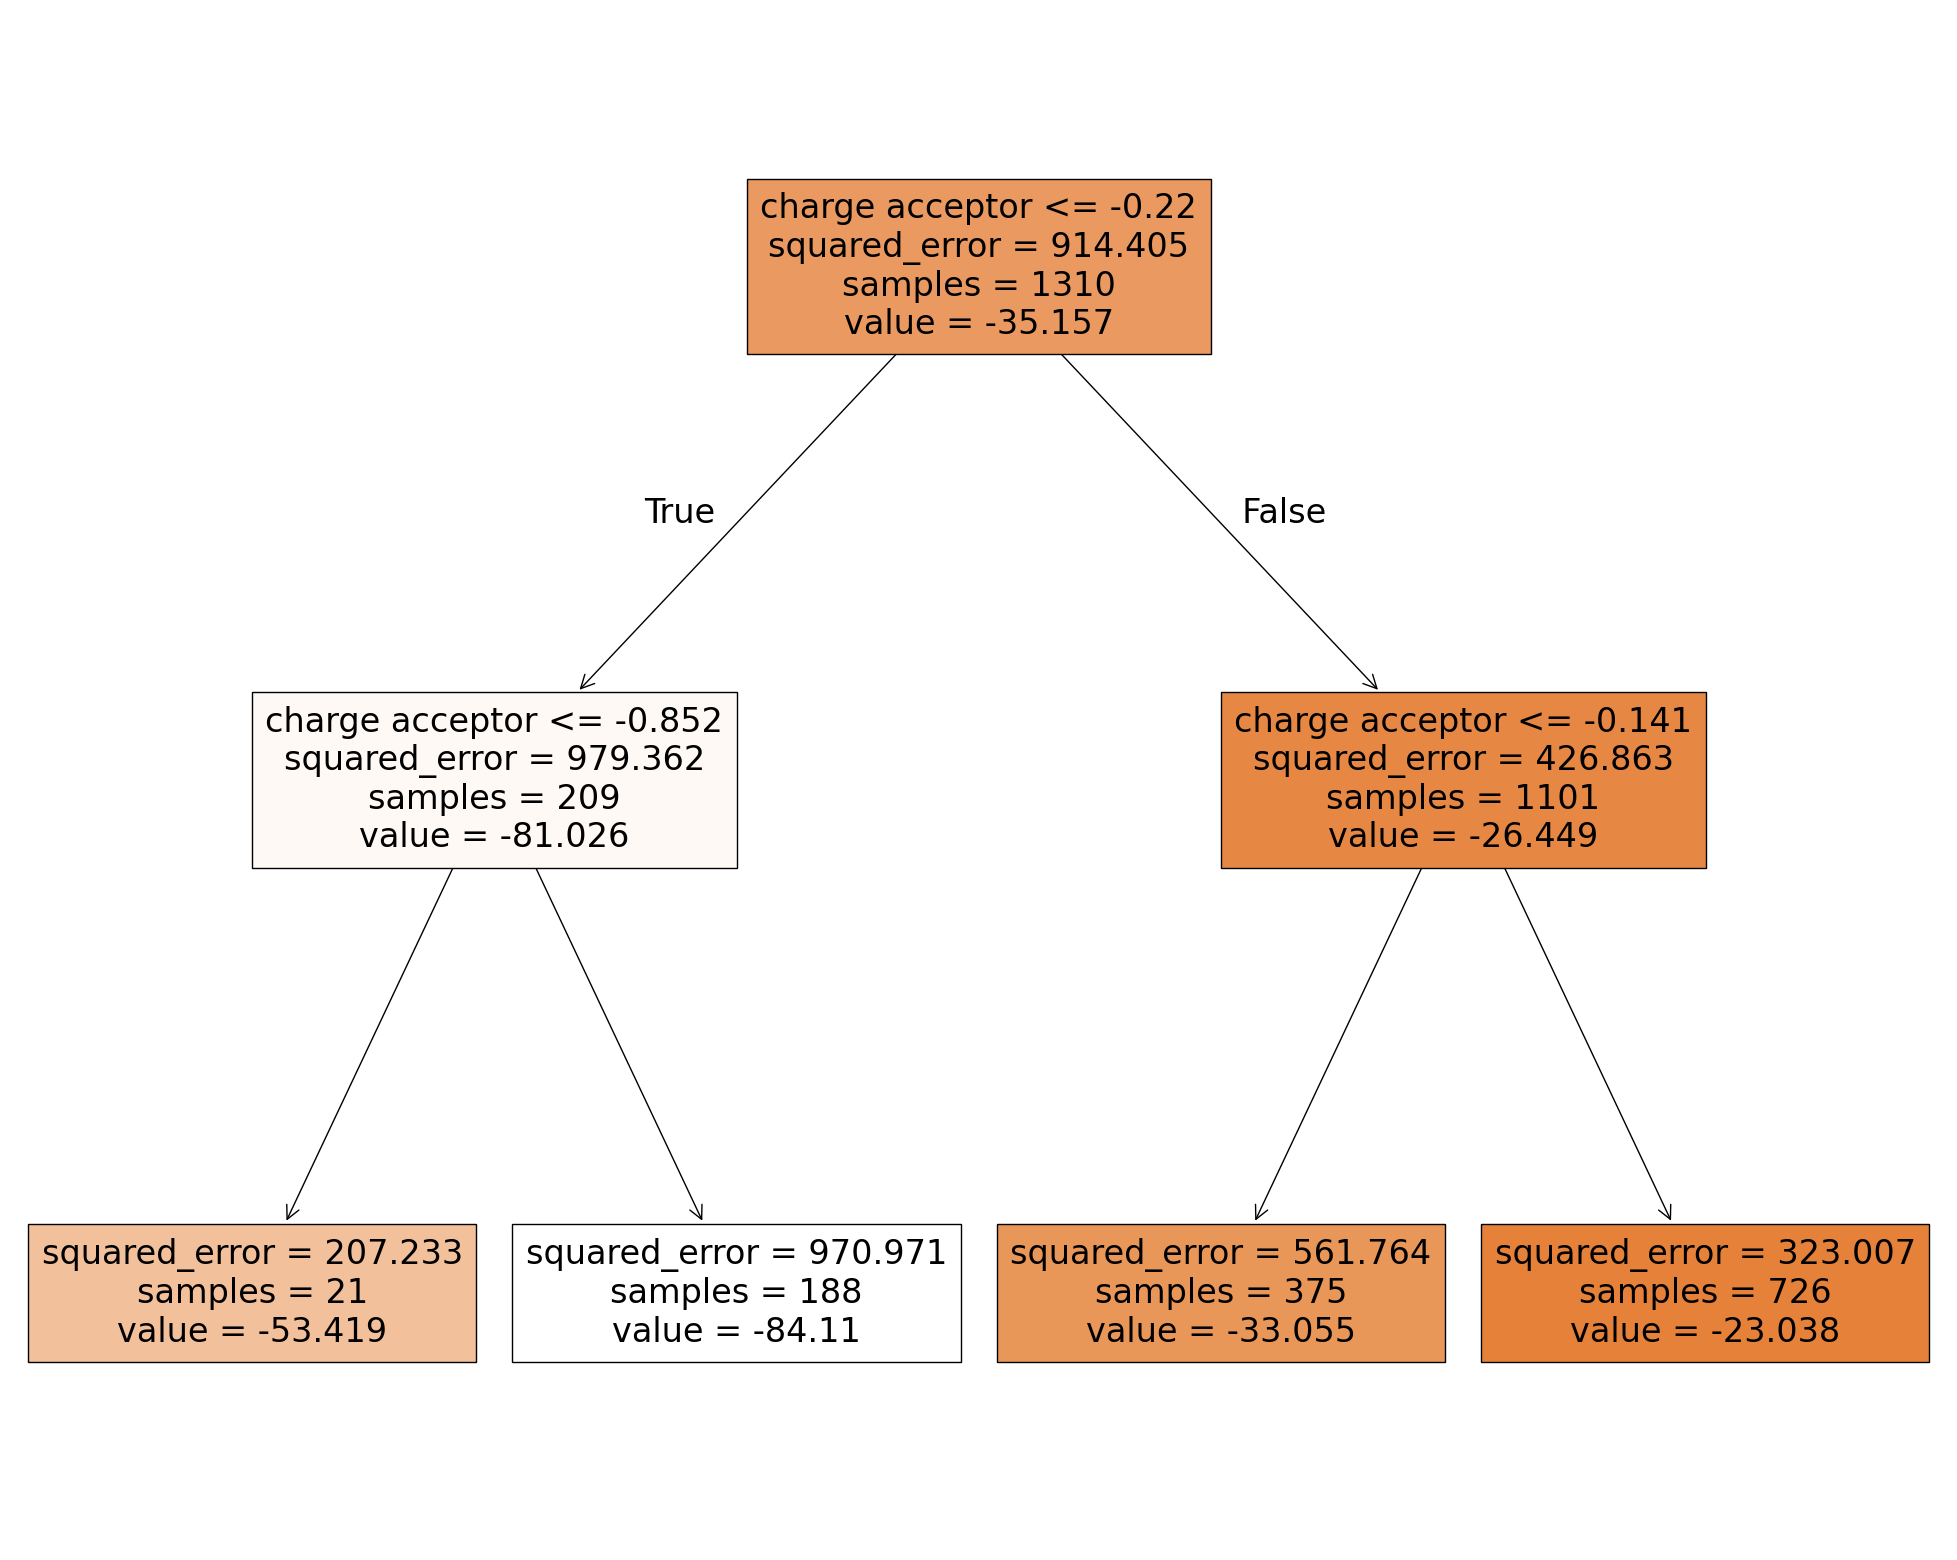

In [1]:
# code from previous notebooks of this section
import pandas as pd
from sklearn.model_selection import train_test_split

hb_data = pd.read_csv('HB_data.csv')
train_set, test_set = train_test_split(hb_data, test_size=0.2, random_state=42)
# end code from previous notebooks of this section

from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree

y_train = train_set['energy']
# We use two brackets on the next line to make a matrix instead of a vector.  
X_train = train_set[['q-acc']]

model_tree = DecisionTreeRegressor(max_depth=2, criterion='squared_error', random_state=42)

model_tree.fit(X_train,y_train)

fig = plt.figure(figsize=(25,20))
treeplot = tree.plot_tree(model_tree,
                   feature_names=['charge acceptor'],
                   filled=True)

The first box is the root node. All training data ("samples = 1310") is on this node. The data is split into two subsets resulting in the two nodes below. The left one consists of 209 samples, the right one of 1101 samples. A hydrogen bond energy of -81.206 kJ/mol (second row, left node) is predicted for an input value less/equal than -0.22 a.u. while it is -26.449 kJ/mol (second row, right node) for larger values. The mean squared error (MSE) is used as impurity score for the model. It is 914.405 kJ/mol (see root node) for the prediction based on the samples of the root node where the prediction is always -35.157 kJ/mol. The partial charge of -0.22 a.u. was selected to split the root node since it minimize the impurity of the next two nodes. The subsequent nodes act similar but use only the data passed to the node to optimize the MSE. The bottom boxes are the leaf nodes which are the final prediction of the model.   

As you can imagine from this example, decision trees are very flexible regression models. They are also computationally efficient and can be used to train models with numerous features and instances. However, they are bad in interpolating and extrapolating since they show a stepwise fit. Furthermore, they strongly depend on the training data. To fix the dependency on the training data, random forests are an ensemble of decision trees trained on different random subsets of the training set. Commonly bagging is employed where instances are taken randomly with replacement from the training data, e.g. the new data set can contain the same instance of the original data set several times. Nonetheless, random forests show still poor performance for inter- and extrapolation due to the stepwise predictions. 

In [2]:
# code from previous notebooks of this section
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)

hb_data = pd.read_csv('HB_data.csv')
train_set, test_set = train_test_split(hb_data, test_size=0.2, random_state=42)

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])
# end code from previous notebooks of this section

from sklearn.ensemble import RandomForestRegressor
 
model_forest = make_pipeline(preprocessing, RandomForestRegressor(min_samples_split=2, n_estimators=100, 
                                                                      criterion='squared_error', random_state=42))

scores = -cross_val_score(model_forest, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square error of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[6.20039389 4.36108597 4.11073983 3.95990658 3.87353018]

This is an average root mean square error of 4.50 kJ/mol with a standard deviation of 0.87 kJ/mol



Thus, this model is not as good as the polynomial models for our example. The hyperparameter criterion sets the function to measure the quality of a split. We can use the absolute error instead if we like to reduce the weight of outliers. The minimum number of samples required to split a node is set by min_samples_split. n_estimators sets the numbers of trees in the forest.   

Random forests have the advantage that they can determine the relative importance of each feature easily. Scikit-learn does this by checking how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. This can be done as follow: 

[(np.float64(0.3840784862281904), 'num__q-acc'),
 (np.float64(0.25286800830658557), 'num__bo-donor'),
 (np.float64(0.18254105585465052), 'num__q-donor'),
 (np.float64(0.07477051640632408), 'num__q-hatom'),
 (np.float64(0.024520316925131888), 'num__dist-ah'),
 (np.float64(0.023382116265997534), 'num__dist-dh'),
 (np.float64(0.022435614588414907), 'cat__atomtype-acc_F'),
 (np.float64(0.020486101713881696), 'num__bo-acc'),
 (np.float64(0.005285003523203828), 'cat__atomtype-don_O'),
 (np.float64(0.0027381601587412444), 'cat__atomtype-don_N'),
 (np.float64(0.0027354143627047792), 'cat__atomtype-acc_N'),
 (np.float64(0.0023563255542269883), 'cat__atomtype-don_S'),
 (np.float64(0.0010909237815835448), 'cat__atomtype-acc_O'),
 (np.float64(0.00031018610075453764), 'cat__atomtype-acc_S'),
 (np.float64(0.00025665224755813215), 'cat__atomtype-don_F'),
 (np.float64(0.00014511798205036697), 'cat__atomtype-acc_Cl')]

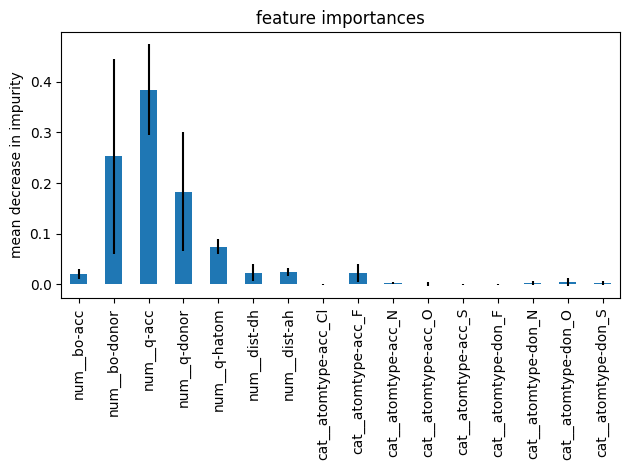

In [3]:
model_forest.fit(X_train, y_train)

feature_importances = model_forest['randomforestregressor'].feature_importances_
std = np.std([tree.feature_importances_ for tree in model_forest['randomforestregressor'].estimators_], axis=0)

forest_importances = pd.Series(feature_importances, index=model_forest['columntransformer'].get_feature_names_out())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("feature importances")
ax.set_ylabel("mean decrease in impurity")
fig.tight_layout()

sorted(zip(feature_importances, model_forest['columntransformer'].get_feature_names_out()),reverse=True)

Please note, feature analysis based on mean decrease in impurity has a bias toward high-cardinality features, e.g. features with many unique categories or levels. Nonetheless, it is very handy to get a quick understanding of what features matter. Thus, it is helpful if you need to perform feature selection.